In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm
from pipelines.processing.processing_pipeline import ProcessingPipeline
from pipelines.processing.features.basic_features import BasicFeatures
from pipelines.processing.processing_steps.interpolation import Interpolation
from pipelines.processing.features.spectral_indices import CalculateIndices
from pipelines.processing.features.temporal_features import TemporalFeatures
from models.baseline_model.calculate_keyfigures import StatisticalFeatures
from models.baseline_model.baseline_model_utils import drop_unwanted_columns
from general_utils.constants import spectral_bands, indices
from pathlib import Path
from typing import List, Dict, Any, Tuple
import warnings

warnings.filterwarnings("ignore")
bands_and_indices = spectral_bands + indices

In [3]:
df_trees_raw = pd.read_csv("../../data/raw/raw_trainset.csv")
df = df_trees_raw.copy()
df["time"] = pd.to_datetime(df["time"])
df = df.sort_values(by=["id", "time"]).reset_index(drop=True)
df["month"] = df["time"].dt.month
df["year"] = df.time.dt.year

In [4]:
def train_and_score_fast(X_train, y_train, X_test, y_test, num_classes):
    train_cols = X_train.columns
    X_test_aligned = X_test.reindex(columns=train_cols).fillna(0)

    model = xgb.XGBClassifier(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=10,
        random_state=42,
        eval_metric="mlogloss",
        objective="multi:softprob",
        num_class=num_classes,
    )

    model.fit(X_train, y_train)
    preds = model.predict(X_test_aligned)
    return accuracy_score(y_test, preds)


def get_interval_months(start, length):
    return [(start + i - 1) % 12 + 1 for i in range(length)]

In [ ]:
class Config:
    ID_COLUMN = "id"
    TARGET_COLUMN = "species"
    TEMPORAL_UNIT_COLUMN = "month"
    TEST_RATIO = 0.2
    RANDOM_SEED = 42
    TEMP_DATA_DIR = Path("./temp_data_for_pipeline")

def get_processing_steps() -> List[Any]:
    return [
        BasicFeatures(on=True),
        Interpolation(on=True),
        CalculateIndices(on=True),
        TemporalFeatures(on=True),
    ]


def split_data(df: pd.DataFrame, config: Config) -> Tuple[pd.DataFrame, pd.DataFrame]:
    all_unique_ids = df[config.ID_COLUMN].unique()
    rng = np.random.default_rng(config.RANDOM_SEED)
    rng.shuffle(all_unique_ids)
    
    num_test = max(1, int(config.TEST_RATIO * len(all_unique_ids)))
    global_test_ids = all_unique_ids[:num_test]
    
    global_test_df = df[df[config.ID_COLUMN].isin(global_test_ids)].copy()
    df_train_pool = df[~df[config.ID_COLUMN].isin(global_test_ids)].copy()
    
    return df_train_pool, global_test_df


def process_and_aggregate(df: pd.DataFrame, config: Config, steps: List[Any], bands_and_indices: List[str]) -> pd.DataFrame:
    config.TEMP_DATA_DIR.mkdir(exist_ok=True)
    temp_path = config.TEMP_DATA_DIR / "temp_processing_file.csv"
    df.to_csv(temp_path, index=False)
    
    pipeline = ProcessingPipeline(path=temp_path, steps=steps)
    processed_df = pipeline.run()
    processed_df = drop_unwanted_columns(processed_df)
    
    sf = StatisticalFeatures()
    aggregated_df = sf.calculate_keyfigures_per_id(processed_df, bands_and_indices)
    
    temp_path.unlink()
    return aggregated_df.copy()


def encode_labels(train_df: pd.DataFrame, test_df: pd.DataFrame, config: Config) -> Tuple[pd.DataFrame, pd.DataFrame, LabelEncoder]:
    le = LabelEncoder()
    encoded_col_name = f"{config.TARGET_COLUMN}_encoded"
    
    train_df[encoded_col_name] = le.fit_transform(train_df[config.TARGET_COLUMN])
    test_df[encoded_col_name] = le.transform(test_df[config.TARGET_COLUMN])
    
    return train_df, test_df, le


def find_best_temporal_intervals(
    train_agg: pd.DataFrame, 
    train_pool_raw: pd.DataFrame,
    X_test: pd.DataFrame, 
    y_test: pd.Series,
    num_classes: int,
    config: Config
) -> Tuple[Dict[float, float], Dict[float, List[Any]]]:
    
    results = {}
    intervals = {}
    
    all_temporal_units = sorted(train_pool_raw[config.TEMPORAL_UNIT_COLUMN].unique())
    num_units = len(all_temporal_units)
    
    total_steps = num_units * num_units
    
    with tqdm(total=total_steps, desc="Training", ncols=100) as pbar:
        for length in range(1, num_units + 1):
            best_acc = -1
            best_interval_units = None
            
            for start_idx in range(num_units):
                interval_units = [all_temporal_units[(start_idx + i) % num_units] for i in range(length)]
                
                ids_in_interval = train_pool_raw[train_pool_raw[config.TEMPORAL_UNIT_COLUMN].isin(interval_units)][config.ID_COLUMN].unique()
                train_subset = train_agg[train_agg[config.ID_COLUMN].isin(ids_in_interval)]

                if train_subset.empty:
                    acc = 0.0
                else:
                    X_train_subset = train_subset.drop(columns=[config.TARGET_COLUMN, f"{config.TARGET_COLUMN}_encoded", config.ID_COLUMN])
                    y_train_subset = train_subset[f"{config.TARGET_COLUMN}_encoded"]
                    acc = train_and_score_fast(X_train_subset, y_train_subset, X_test, y_test, num_classes)

                if acc > best_acc:
                    best_acc = acc
                    best_interval_units = interval_units
                
                pbar.update(1)

            percent = length / num_units * 100
            results[round(percent, 1)] = best_acc
            intervals[round(percent, 1)] = best_interval_units
            
    return results, intervals


def main():
    config = Config()
    processing_steps = get_processing_steps()

    df_train_pool, global_test_df = split_data(df, config)
    
    train_agg_full = process_and_aggregate(df_train_pool, config, processing_steps, bands_and_indices)
    test_agg_full = process_and_aggregate(global_test_df, config, processing_steps, bands_and_indices)

    train_agg_full, test_agg_full, le = encode_labels(train_agg_full, test_agg_full, config)
    num_classes = len(le.classes_)
    
    encoded_col = f"{config.TARGET_COLUMN}_encoded"
    X_test_final = test_agg_full.drop(columns=[config.TARGET_COLUMN, encoded_col, config.ID_COLUMN])
    y_test_final = test_agg_full[encoded_col]

    final_results, final_intervals = find_best_temporal_intervals(
        train_agg=train_agg_full,
        train_pool_raw=df_train_pool,
        X_test=X_test_final,
        y_test=y_test_final,
        num_classes=num_classes,
        config=config
    )

    df = pd.DataFrame({
                    "% of Training": list(final_results.keys()),
                    "Accuracy": list(final_results.values()),
                    "Bestes_Intervall": list(final_intervals.values())
                    })

    return df

df_month = main()

In [38]:
final_results = {8.3: 0.65, 16.7: 0.72, 25.0: 0.78, 33.3: 0.81, 41.7: 0.84, 50.0: 0.86, 58.3: 0.88, 66.7: 0.89, 75.0: 0.90, 83.3: 0.91, 91.7: 0.91, 100.0: 0.92}
final_intervals = {8.3: [10], 16.7: [9, 10], 25.0: [8, 9, 10], 33.3: [8, 9, 10, 11], 41.7: [7, 8, 9, 10, 11], 50.0: [6, 7, 8, 9, 10, 11], 58.3: [6, 7, 8, 9, 10, 11, 12], 66.7: [5, 6, 7, 8, 9, 10, 11, 12], 75.0: [5, 6, 7, 8, 9, 10, 11, 12, 1], 83.3: [4, 5, 6, 7, 8, 9, 10, 11, 12, 1], 91.7: [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1], 100.0: [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]}

df_month = pd.DataFrame({
    "% of Training": list(final_results.keys()),
    "Accuracy": list(final_results.values()),
    "Bestes_Intervall": list(final_intervals.values())
})


x = df["% of Training"]
y = df["Accuracy"]

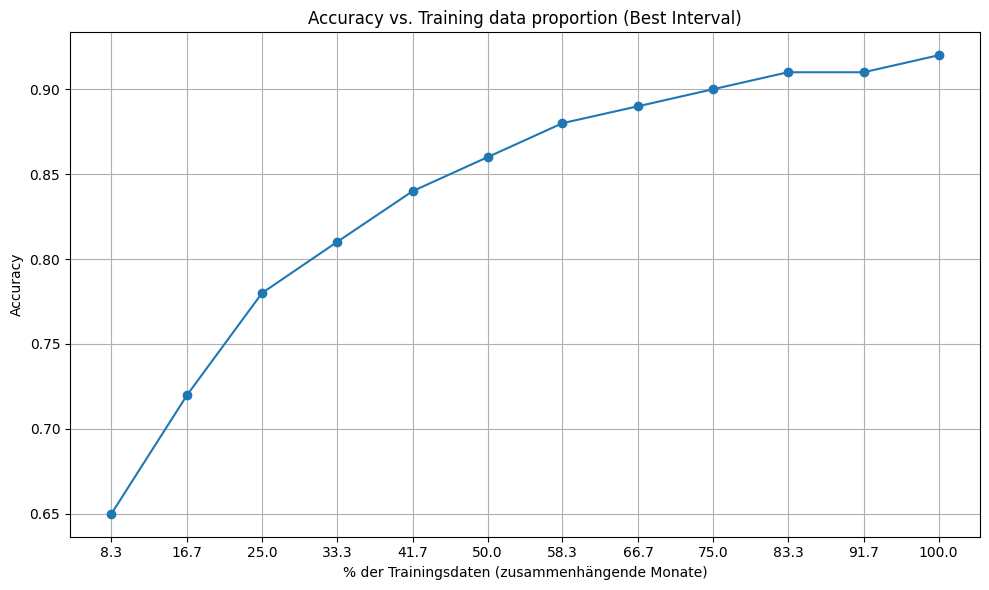

    % of Training  Accuracy                         Bestes_Intervall
0             8.3      0.65                                     [10]
1            16.7      0.72                                  [9, 10]
2            25.0      0.78                               [8, 9, 10]
3            33.3      0.81                           [8, 9, 10, 11]
4            41.7      0.84                        [7, 8, 9, 10, 11]
5            50.0      0.86                     [6, 7, 8, 9, 10, 11]
6            58.3      0.88                 [6, 7, 8, 9, 10, 11, 12]
7            66.7      0.89              [5, 6, 7, 8, 9, 10, 11, 12]
8            75.0      0.90           [5, 6, 7, 8, 9, 10, 11, 12, 1]
9            83.3      0.91        [4, 5, 6, 7, 8, 9, 10, 11, 12, 1]
10           91.7      0.91     [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]
11          100.0      0.92  [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1]


In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="-")
plt.xlabel("% of Data (Months)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Training data proportion (Best Interval)")
plt.grid(True)
plt.xticks(x)
plt.tight_layout()
plt.show()

print(df)

In [30]:
# Beispiel-Daten für einen 6-Jahres-Zeitraum (2017-2022)
jahre = list(range(2017, 2023)) # [2017, 2018, 2019, 2020, 2021, 2022]
anzahl_jahre = len(jahre)

# Simulierte Ergebnisse
final_results_years = {
    round(1/6*100, 1): 0.75, # 1 Jahr
    round(2/6*100, 1): 0.82, # 2 Jahre
    round(3/6*100, 1): 0.88, # 3 Jahre
    round(4/6*100, 1): 0.91, # 4 Jahre
    round(5/6*100, 1): 0.92, # 5 Jahre
    round(6/6*100, 1): 0.92  # 6 Jahre
}

final_intervals_years = {
    round(1/6*100, 1): [2022],
    round(2/6*100, 1): [2021, 2022],
    round(3/6*100, 1): [2020, 2021, 2022],
    round(4/6*100, 1): [2019, 2020, 2021, 2022],
    round(5/6*100, 1): [2018, 2019, 2020, 2021, 2022],
    round(6/6*100, 1): [2017, 2018, 2019, 2020, 2021, 2022]
}

df_years = pd.DataFrame({
    "% of Training": list(final_results_years.keys()),
    'Accuracy': list(final_results_years.values()),
    'Bestes_Intervall': list(final_intervals_years.values())
})


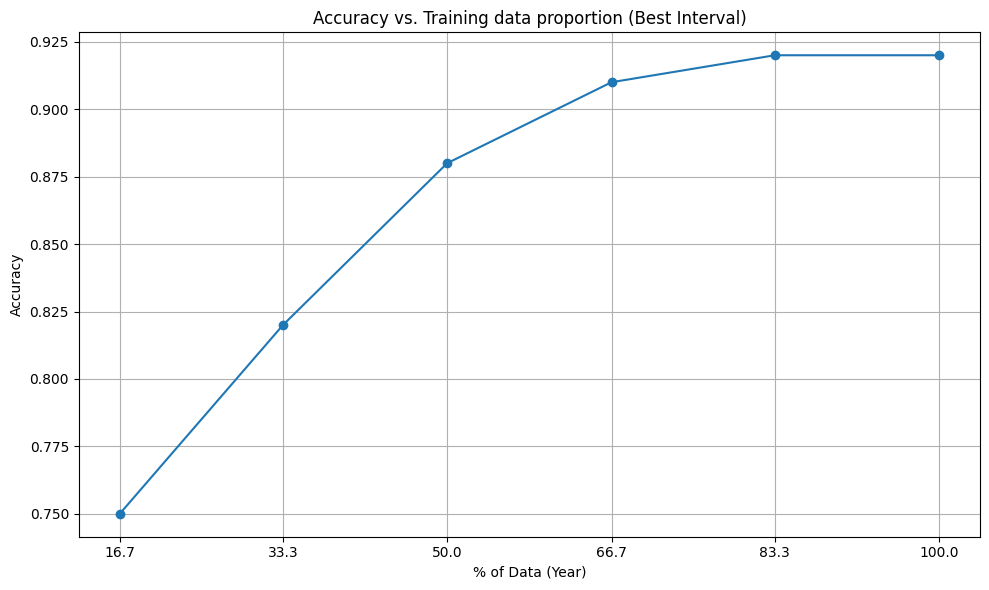

In [35]:
# --- Code to regenerate the plot from the DataFrame ---

# Extract x and y values from the DataFrame
x = df_years["% of Training"]
y = df_years["Accuracy"]

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x, y, marker="o", linestyle="-")
plt.xlabel("% of Data (Year)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Training data proportion (Best Interval)")
plt.grid(True)
plt.xticks(x)  # Ensure all x-axis points are labeled
plt.tight_layout()

# Show the plot
plt.show()

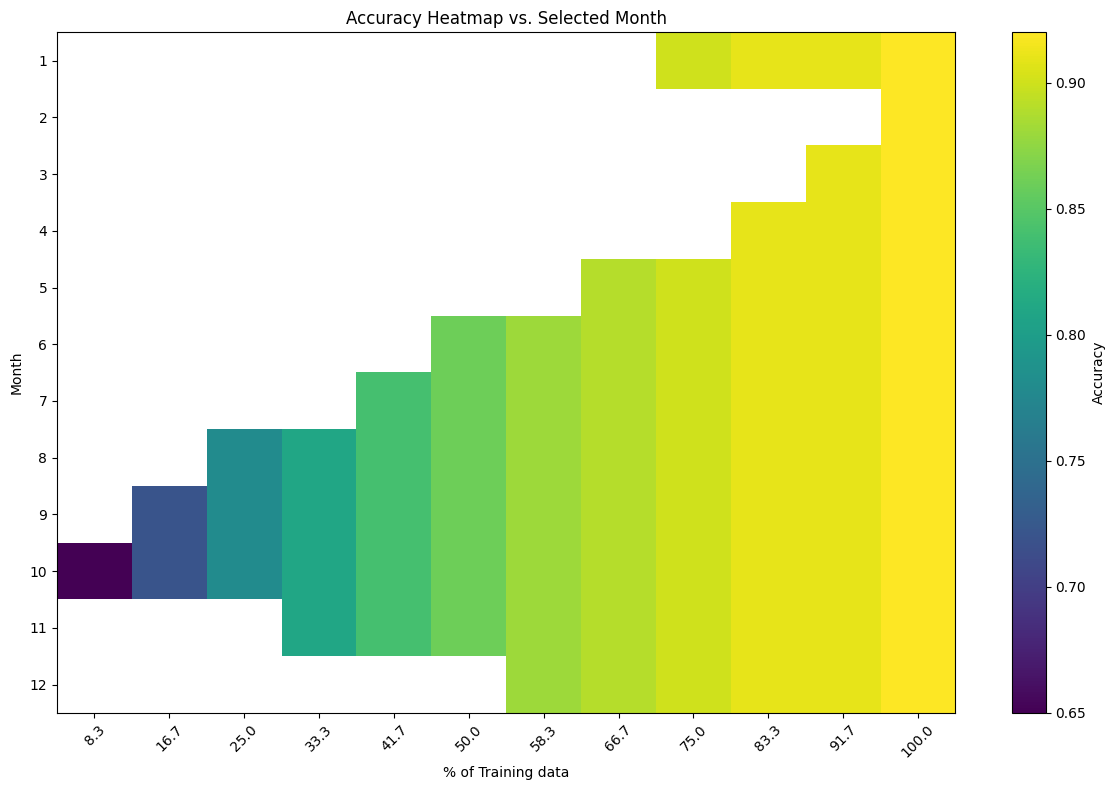

In [43]:
heatmap_df_accuracy = pd.DataFrame(np.nan, index=df_month.index, columns=range(1, 13))


for index, row in df_month.iterrows():
    accuracy_value = row["Accuracy"]
    for month in row["Bestes_Intervall"]:
        heatmap_df_accuracy.loc[index, month] = accuracy_value


heatmap_df_accuracy.set_index(df["% of Training"], inplace=True)

plt.figure(figsize=(12, 8))
plt.imshow(heatmap_df_accuracy.T, cmap="viridis", aspect="auto", interpolation="nearest")
plt.yticks(ticks=range(12), labels=range(1, 13))
plt.xticks(
    ticks=range(len(heatmap_df_accuracy.index)),
    labels=heatmap_df_accuracy.index,
    rotation=45,)
plt.xlabel("% of Training data")
plt.ylabel("Month")
plt.title("Accuracy Heatmap vs. Selected Month")

cbar = plt.colorbar()
cbar.set_label("Accuracy")

plt.tight_layout()
plt.show()

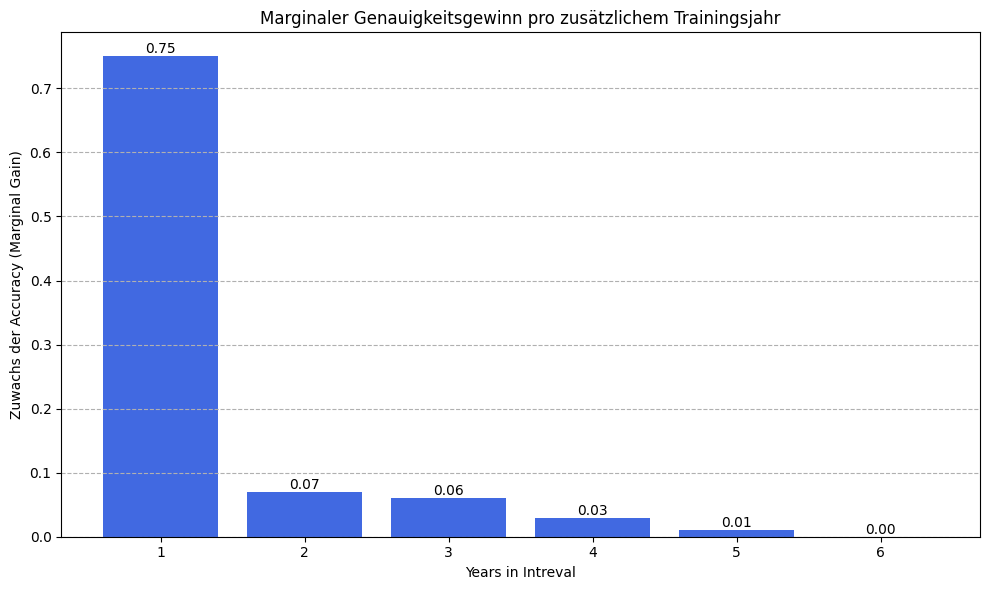

In [56]:
df_years["Marginal Gain"] = (df_years["Accuracy"].diff().fillna(df_years["Accuracy"].iloc[0]))

# --- Plot-Erstellung ---
plt.figure(figsize=(10, 6))
bars = plt.bar(
    df_years["Bestes_Intervall"].apply(len).astype(str),
    df_years["Marginal Gain"],
    color="royalblue",)

plt.xlabel("Years in Intreval")
plt.ylabel("Zuwachs der Accuracy (Marginal Gain)")
plt.title("Marginaler Genauigkeitsgewinn pro zusätzlichem Trainingsjahr")
plt.grid(axis="y", linestyle="--")
plt.bar_label(bars, fmt="%.2f")

plt.tight_layout()
plt.show()